In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
path = "/content/gdrive/My Drive/Colab Notebooks"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import re, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
!pip install -Uqq fastbook

import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.tabular.all import *

from fastai.tabular import *
from fastai.tabular.all import *
from fastai.tabular.data import *
from fastai.tabular.learner import *
from fastai.metrics import *

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
data = pd.read_csv(path + r"/data_shuf.csv")
alist = data.columns.to_list()
alist

['pop2012',
 'night2012',
 'road_len',
 'cen_dist',
 'city_pop_total',
 'land_cover']

In [7]:
cat = alist[-1]
cont = alist[1:-1]
y_names = alist[0]
procs = [Categorify,]

In [8]:
percent, length = 0.8, len(data.axes[0])
stop = int(percent * length)
valid_idx = list(range(stop,length))

In [9]:
dls = TabularDataLoaders.from_df(data, procs=procs, cat_names=cat, cont_names=cont,
                y_names=y_names,  valid_idx=valid_idx, bs=64, shuffle_train=True, device=device)

In [10]:
dls.show_batch()

,land_cover,night2012,road_len,cen_dist,city_pop_total,pop2012
0,7,0.021028,0.112946,0.113418,0.032551,0.001355
1,7,0.016889,0.355973,0.156978,0.020128,0.012148
2,7,0.021862,0.250673,0.063429,0.035850,0.032114
3,7,0.001435,0.000000,0.126439,0.023663,0.000064
4,7,0.003505,0.022939,0.121648,0.022778,0.000000
5,7,0.001936,0.000000,0.539767,0.737284,0.000061
6,7,0.001569,0.130987,0.130815,0.032551,0.000124
7,7,0.004406,0.066717,0.149575,0.044978,0.000000
8,7,0.002003,0.052069,0.177310,0.027283,0.001081
9,2,0.048665,0.209484,0.060081,0.004890,0.024675


In [11]:
# 2 Hidden Layers with 1000 and 500 activations
learn = tabular_learner(dls, layers=[1000,500], metrics=rmse)

In [12]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=10, out_features=1000, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=1000, out_features=500, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=500, out_features=1, bias=True)
    )
  )
)

Learning rate is now, 6.918309954926372e-05


epoch,train_loss,valid_loss,_rmse,time
0,0.001005,0.002131,0.046163,00:52
1,0.000442,0.000459,0.021416,00:52
2,0.000459,0.000350,0.018707,00:51
3,0.000358,0.000278,0.016677,00:53
4,0.000226,0.000268,0.016362,00:52


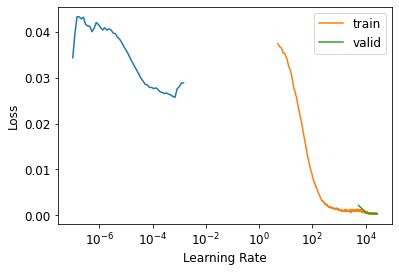

In [13]:
epoch = 5
lr = learn.lr_find()[0]
print('Learning rate is now,', lr)
learn.fit_one_cycle(epoch, lr)
learn.recorder.plot_loss()

Learning rate is now, 1.318256749982538e-07


epoch,train_loss,valid_loss,_rmse,time
0,0.000327,0.000268,0.016361,00:51
1,0.000251,0.000269,0.016409,00:53
2,0.000249,0.000272,0.016477,00:52
3,0.000246,0.000266,0.016295,00:52
4,0.000264,0.000271,0.016448,00:51


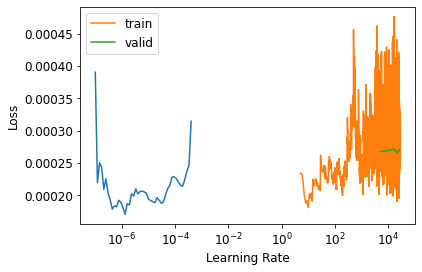

In [14]:
epoch = 5
lr = learn.lr_find()[0]
print('Learning rate is now,', lr)
learn.fit_one_cycle(epoch, lr)
learn.recorder.plot_loss()

Learning rate is now, 6.309573450380412e-08


epoch,train_loss,valid_loss,_rmse,time
0,0.000289,0.000263,0.016203,00:52
1,0.000295,0.000266,0.016321,00:51
2,0.000358,0.000264,0.016262,00:52
3,0.000244,0.000270,0.016447,00:52
4,0.000292,0.000268,0.016386,00:52
5,0.000285,0.000268,0.016381,00:52
6,0.000316,0.000268,0.016383,00:53
7,0.000243,0.000267,0.016330,00:52
8,0.000258,0.000266,0.016320,00:53
9,0.000372,0.000270,0.016437,00:52


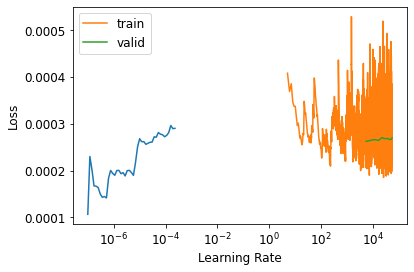

In [16]:
epoch = 10
lr = learn.lr_find()[0]
print('Learning rate is now,', lr)
learn.fit_one_cycle(epoch, lr)
learn.recorder.plot_loss()
rmse = learn.metrics[-1].value.tolist()

In [18]:
std = data.describe().to_dict()['pop2012']['std']
R2 = 1 - (rmse / std) ** 2
R2

0.7395124980144978

In [19]:
learn.show_results()

,land_cover,night2012,road_len,cen_dist,city_pop_total,pop2012,pop2012_pred
0,7.0,0.014119,0.061794,0.115248,0.044978,0.000055,0.001847
1,7.0,0.023097,0.026206,0.189918,0.083631,0.002023,0.001598
2,10.0,0.017156,0.069904,0.432643,0.101936,0.000169,-0.000929
3,7.0,0.019593,0.057677,0.361870,0.737284,0.000000,0.000992
4,5.0,0.014286,0.000000,0.260898,0.737284,0.000379,0.005625
5,8.0,0.060848,0.191459,0.105862,0.044978,0.001605,0.022141
6,8.0,0.000601,0.003308,0.461520,0.136440,0.000000,0.003412
7,7.0,0.000701,0.010005,0.273354,0.020128,0.000000,-0.000508
8,7.0,0.037150,0.000000,0.246008,0.350438,0.000073,-0.005585


In [20]:
learn.export(path + "/DL.pkl")
print("Model Saved!")

Model Saved!


## Now Prediction!

In [21]:
# predict with the model
data_new = pd.read_csv(path+"/data_new.csv")

In [22]:
learn_inf = load_learner(path+"/DL.pkl")

To get prediction on a new dataframe, you can use the test_dl method of the DataLoaders. That dataframe does not need to have the dependent variable in its column.


In [23]:
row, clas, probs = learn_inf.predict(data_new.iloc[0])
row.show()

,land_cover,night2012,road_len,cen_dist,city_pop_total,pop2012
0,1,0.100334,0.346998,0.030507,0.002319,0.099282


In [24]:
# Copy in the csv
data = pd.read_csv(path+r"/data.csv")

In [25]:
data['pop_pred_DL'] = 0

In [ ]:
for i in range(length):
    data.loc[i,'pop_pred_DL'] = learn_inf.predict(data_new.iloc[i])[0]['pop2012'].item()

In [ ]:
# Transform to the pre-normalized state
maxi = 57586.267532
data['pop_pred_DL'] *= maxi

In [ ]:
data.head()

In [ ]:
data.to_csv(path+r"/data_preds.csv",index=False)
print('File Exported!')